In [54]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [62]:
DATA_TYPE = "PBMC10k"
#METHOD = "threshold"  
METHOD = "scopen_cicero"
#METHOD = "celltypist_cicero_scopen"

BEST_DICT = {"scopen_cicero": "0.4",
             "celltypist_cicero_scopen": "0.4"}

if METHOD != 'threshold':
    BEST = BEST_DICT[METHOD]
    METRICS_PKL = Path(f"~/Datasets/{DATA_TYPE}/output/{METHOD}/matrix_{BEST}/metrics.pkl").expanduser()
    OUTDIR      = Path(f"~/Datasets/{DATA_TYPE}/output/{METHOD}/plots").expanduser()
else:
    METRICS_PKL = Path(f"~/Datasets/{DATA_TYPE}/output/{METHOD}/metrics_threshold.pkl").expanduser()
    OUTDIR      = Path(f"~/Datasets/{DATA_TYPE}/output/{METHOD}/plots").expanduser()

LABELS_TSV  = Path(f"~/Datasets/{DATA_TYPE}/input/labels.tsv").expanduser()


In [63]:
def load_embeddings(metrics_path):
    metrics_path = Path(metrics_path).expanduser()
    print("[DEBUG] metrics_path =", metrics_path)
    with open(metrics_path, "rb") as f:
        return pickle.load(f)

def load_labels(labels_path, sep="\t", header=False, label_col=1):
    labels_path = Path(labels_path).expanduser()
    header_opt = 0 if header else None
    df = pd.read_csv(labels_path, sep=sep, header=header_opt)
    return df.iloc[:, label_col].astype(str).values

def adjust_lengths(embedding, labels):
    n_emb = embedding.shape[0]
    n_lab = len(labels)
    if n_emb != n_lab:
        print(f"[WARN] embedding n={n_emb}, labels n={n_lab}, усечение до {min(n_emb,n_lab)}")
        m = min(n_emb, n_lab)
        return embedding[:m], labels[:m]
    return embedding, labels


def plot_embedding(name, emb, labels, outdir):
    outdir = Path(outdir).expanduser()
    outdir.mkdir(parents=True, exist_ok=True)

    # Преобразуем строковые метки в числа
    label_ids, label_uniques = pd.factorize(labels)
    n_classes = len(label_uniques)

    # Подбираем цветовую карту
    if n_classes <= 10:
        cmap = plt.cm.get_cmap("tab10", n_classes)
    elif n_classes <= 20:
        cmap = plt.cm.get_cmap("tab20", n_classes)
    else:
        cmap = plt.cm.get_cmap("gist_ncar", n_classes)  # до 256 контрастных цветов

    colors = cmap(range(n_classes))

    # === Основной scatter ===
    plt.figure(figsize=(8, 8))
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        c=colors[label_ids],
        s=6,
        alpha=0.85,
        linewidths=0,
    )
    plt.title(f"{name.upper()} embedding")

    # === Легенда ===
    # показываем только если не слишком много классов
    if n_classes <= 20:
        for uid, lab in enumerate(label_uniques):
            plt.scatter([], [], c=[colors[uid]], s=40, label=str(lab))  
            # пустой scatter нужен, чтобы легенда была корректной

        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title="Cell types",
            fontsize=8,
            title_fontsize=10
        )

    plt.tight_layout()

    out_path = outdir / f"{name}.png"
    plt.savefig(out_path, dpi=300)
    plt.show()

    print(f"[INFO] Saved {name} → {out_path}")


[INFO] Загружаем: /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/matrix_0.4/metrics.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/matrix_0.4/metrics.pkl
[INFO] Найдены ключи: ['tsne_embedding', 'pca_embedding', 'umap_embedding']
[INFO] Загружаем labels: /home/salimovdr/Datasets/PBMC10k/input/labels.tsv
[INFO] Загружено меток: 10032


/tmp/ipykernel_1087980/1244545315.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_classes)


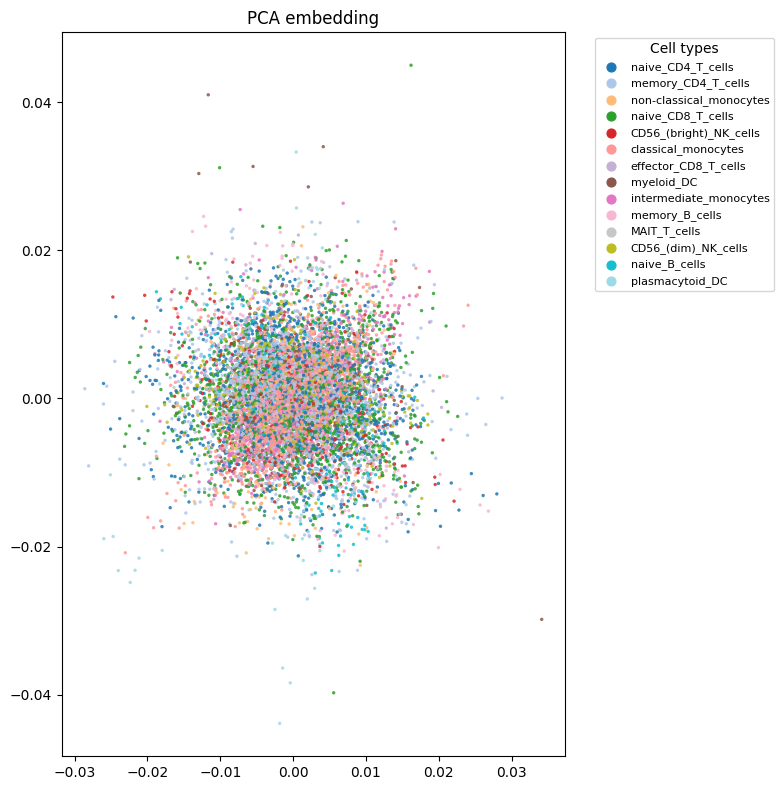

[INFO] Saved pca → /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/plots/pca.png


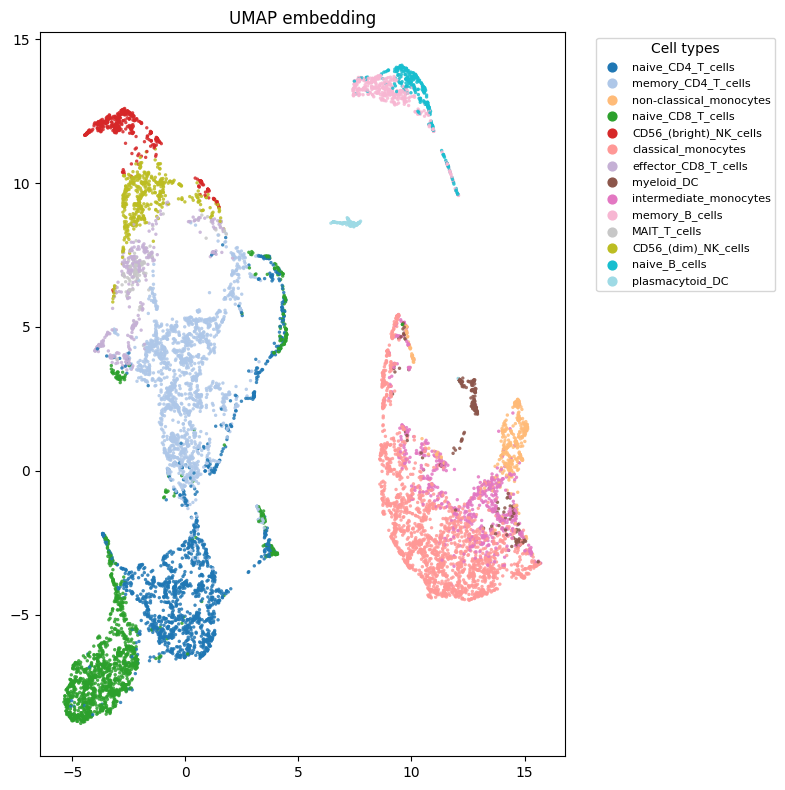

[INFO] Saved umap → /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/plots/umap.png


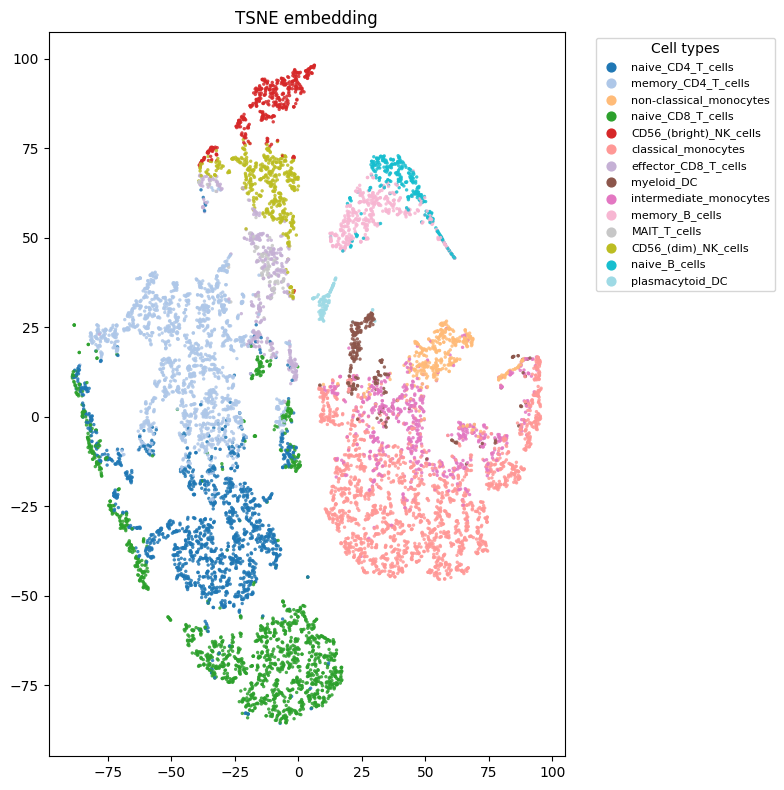

[INFO] Saved tsne → /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/plots/tsne.png


In [64]:
# === Загружаем embeddings ===
print("[INFO] Загружаем:", METRICS_PKL)
emb = load_embeddings(METRICS_PKL)
print("[INFO] Найдены ключи:", list(emb.keys()))

# === Загружаем метки ===
print("[INFO] Загружаем labels:", LABELS_TSV)
labels = load_labels(LABELS_TSV, sep='\t', header=False, label_col=1)
print("[INFO] Загружено меток:", len(labels))

# === PCA ===
if "pca_embedding" in emb:
    pca = np.asarray(emb["pca_embedding"])
    pca, labels_pca = adjust_lengths(pca, labels)
    plot_embedding("pca", pca, labels_pca, OUTDIR)
else:
    print("[WARN] pca_embedding отсутствует в metrics.pkl")

# === UMAP ===
if "umap_embedding" in emb:
    umap = np.asarray(emb["umap_embedding"])
    umap, labels_umap = adjust_lengths(umap, labels)
    plot_embedding("umap", umap, labels_umap, OUTDIR)
else:
    print("[WARN] umap_embedding отсутствует в metrics.pkl")

# === tSNE ===
if "tsne_embedding" in emb:
    tsne = np.asarray(emb["tsne_embedding"])
    tsne, labels_tsne = adjust_lengths(tsne, labels)
    plot_embedding("tsne", tsne, labels_tsne, OUTDIR)
else:
    print("[WARN] tsne_embedding отсутствует в metrics.pkl")


[INFO] Число типов клеток: 14
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/threshold/metrics_threshold.pkl
[INFO] threshold: keys in metrics = dict_keys(['tsne_embedding', 'pca_embedding', 'umap_embedding'])
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/matrix_0.4/metrics.pkl
[INFO] cicero + scOpen: keys in metrics = dict_keys(['tsne_embedding', 'pca_embedding', 'umap_embedding'])
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/celltypist_cicero_scopen/matrix_0.4/metrics.pkl
[INFO] celltypist + cicero + scOpen: keys in metrics = dict_keys(['tsne_embedding', 'pca_embedding', 'umap_embedding'])


/tmp/ipykernel_1087980/3278823240.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_classes)


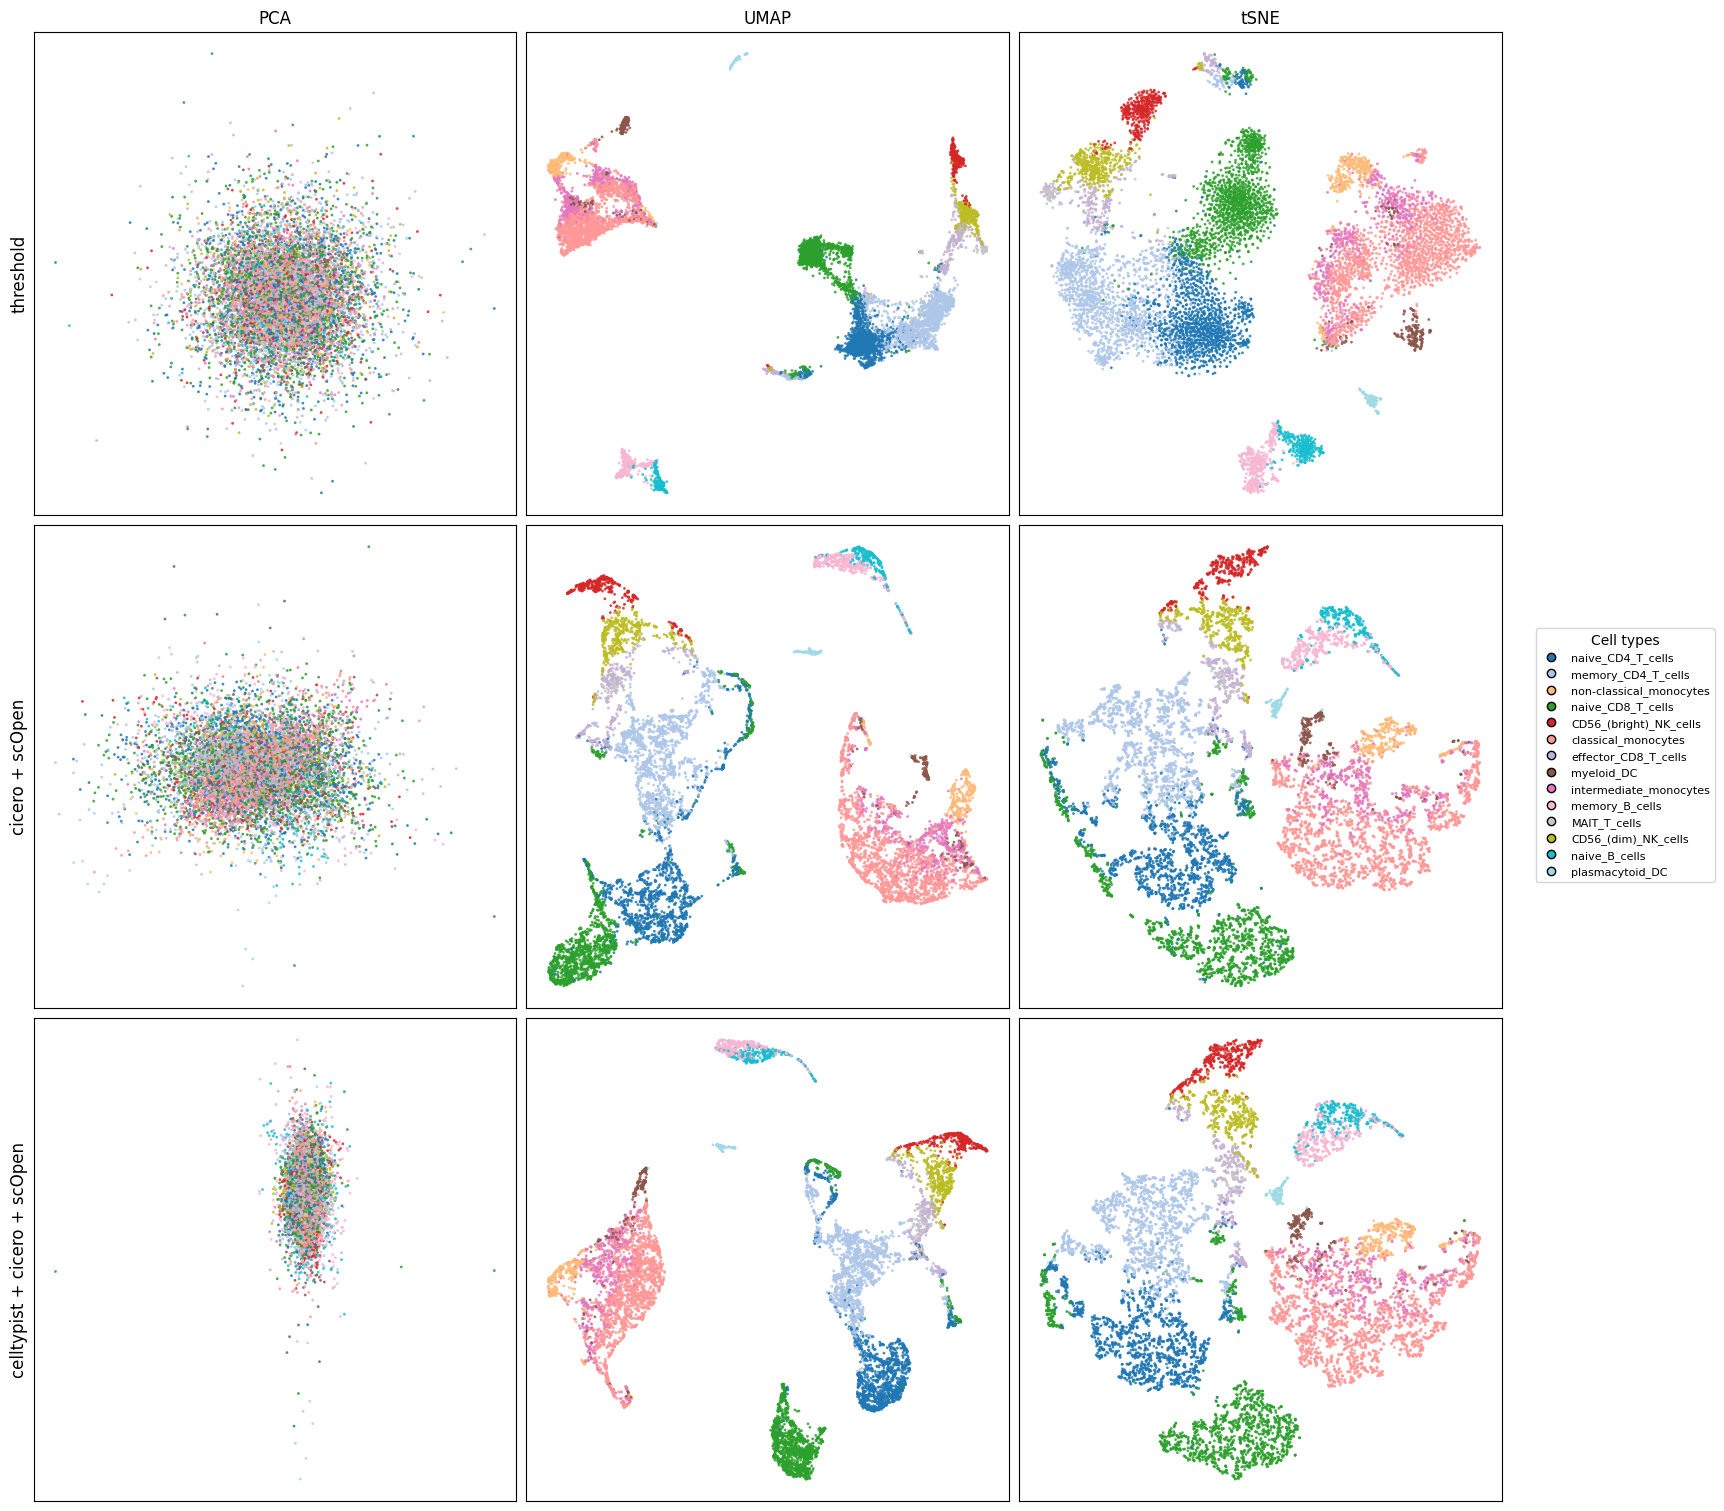

[INFO] Фигура сохранена в /home/salimovdr/Datasets/PBMC10k/output/combined_embeddings_3x3.png


In [66]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === базовые настройки ===
DATA_TYPE = "PBMC10k"

# Пути к metrics.pkl для всех трёх методов
metrics_paths = {
    "threshold": Path(f"~/Datasets/{DATA_TYPE}/output/threshold/metrics_threshold.pkl").expanduser(),
    "cicero + scOpen": Path(f"~/Datasets/{DATA_TYPE}/output/scopen_cicero/matrix_0.4/metrics.pkl").expanduser(),
    "celltypist + cicero + scOpen": Path(f"~/Datasets/{DATA_TYPE}/output/celltypist_cicero_scopen/matrix_0.4/metrics.pkl").expanduser(),
}

# labels общий
LABELS_TSV = Path(f"~/Datasets/{DATA_TYPE}/input/labels.tsv").expanduser()

# файл, куда сохранить общую картинку
OUT_FIG = Path(f"~/Datasets/{DATA_TYPE}/output/combined_embeddings_3x3.png").expanduser()


def align_for_plot(emb, labels, color_ids):
    """
    Подгоняем длины: если embeddings / labels / colors разной длины,
    усекаем до общего минимума.
    """
    n_emb = emb.shape[0]
    n_lab = len(labels)
    n_col = len(color_ids)
    if n_emb != n_lab or n_lab != n_col:
        m = min(n_emb, n_lab, n_col)
        print(f"[WARN] n_emb={n_emb}, n_lab={n_lab}, n_col={n_col} → усечение до {m}")
        return emb[:m], labels[:m], color_ids[:m]
    return emb, labels, color_ids


# === загружаем labels и задаём ОДНУ схему цветов для всех методов ===
labels_all = load_labels(LABELS_TSV, sep="\t", header=False, label_col=1)
label_ids_all, label_uniques = pd.factorize(labels_all)
n_classes = len(label_uniques)

print("[INFO] Число типов клеток:", n_classes)

# общая цветовая схема
if n_classes <= 10:
    cmap = plt.cm.get_cmap("tab10", n_classes)
elif n_classes <= 20:
    cmap = plt.cm.get_cmap("tab20", n_classes)
else:
    cmap = plt.cm.get_cmap("gist_ncar", n_classes)

base_colors = cmap(range(n_classes))
color_ids_all = base_colors[label_ids_all]

# === создаём холст 3×3 ===
fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(15, 15),
    constrained_layout=True
)

row_methods = [
    "threshold",
    "cicero + scOpen",
    "celltypist + cicero + scOpen",
]

emb_types = [
    ("pca_embedding",  "PCA"),
    ("umap_embedding", "UMAP"),
    ("tsne_embedding", "tSNE"),
]

for i, method in enumerate(row_methods):
    emb_dict = load_embeddings(metrics_paths[method])
    print(f"[INFO] {method}: keys in metrics =", emb_dict.keys())

    for j, (emb_key, emb_name) in enumerate(emb_types):
        ax = axes[i, j]

        if emb_key not in emb_dict:
            ax.text(0.5, 0.5, f"{emb_name}\nнет в metrics.pkl",
                    ha="center", va="center", fontsize=10)
            ax.axis("off")
            continue

        emb = np.asarray(emb_dict[emb_key])
        emb, labels_plot, colors_plot = align_for_plot(emb, labels_all, color_ids_all)

        ax.scatter(
            emb[:, 0],
            emb[:, 1],
            c=colors_plot,
            s=4,
            alpha=0.85,
            linewidths=0
        )

        if i == 0:
            ax.set_title(emb_name, fontsize=12)

        if j == 0:
            ax.set_ylabel(method, fontsize=12)

        ax.set_xticks([])
        ax.set_yticks([])

# === общая легенда справа ===
if n_classes <= 20:
    legend_handles = []
    for uid, lab in enumerate(label_uniques):
        h = plt.Line2D(
            [0], [0],
            marker='o',
            color='none',
            markerfacecolor=base_colors[uid],
            markersize=6,
            label=str(lab)
        )
        legend_handles.append(h)

    fig.legend(
        handles=legend_handles,
        title="Cell types",
        fontsize=8,
        title_fontsize=10,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
    )

#plt.suptitle(f"{DATA_TYPE}: PCA / UMAP / tSNE для threshold / scOpen / celltypist+scOpen",
#             fontsize=14)
plt.savefig(OUT_FIG, dpi=300, bbox_inches="tight")
plt.show()

print("[INFO] Фигура сохранена в", OUT_FIG)


[INFO] Строим холст: PCA
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/threshold/metrics_threshold.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/matrix_0.4/metrics.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/celltypist_cicero_scopen/matrix_0.4/metrics.pkl


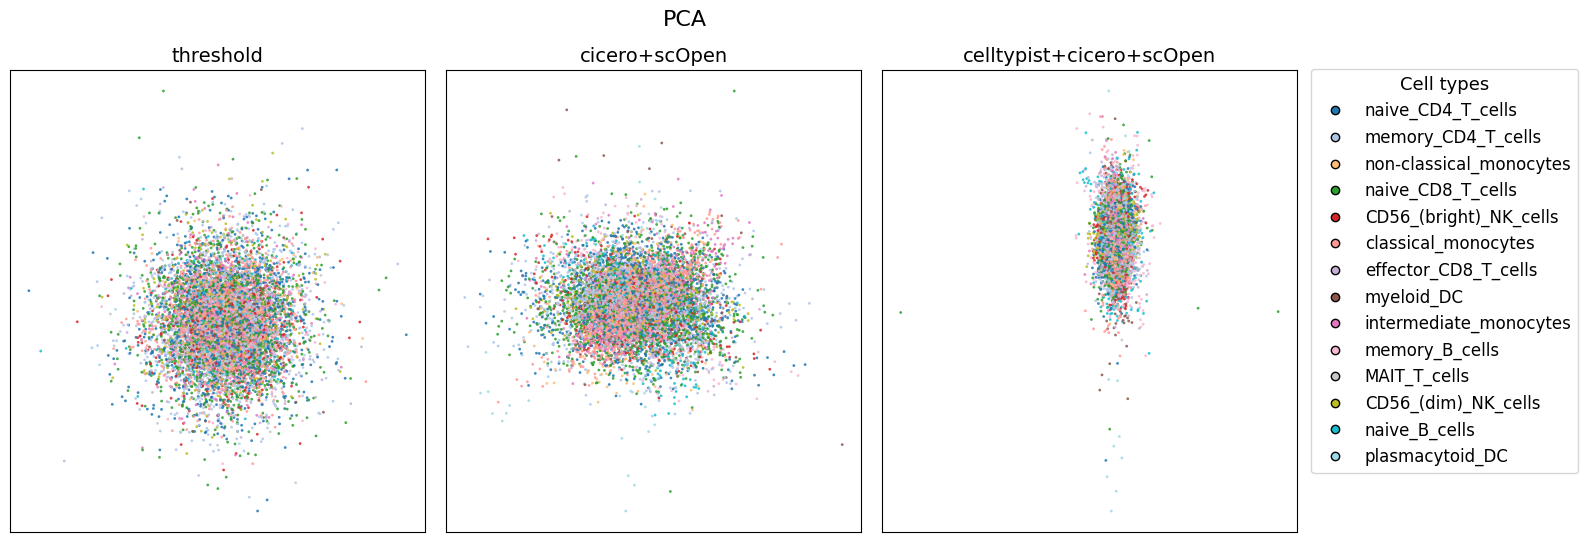

[INFO] Сохранено → canvas_PCA.png
[INFO] Строим холст: UMAP
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/threshold/metrics_threshold.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/matrix_0.4/metrics.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/celltypist_cicero_scopen/matrix_0.4/metrics.pkl


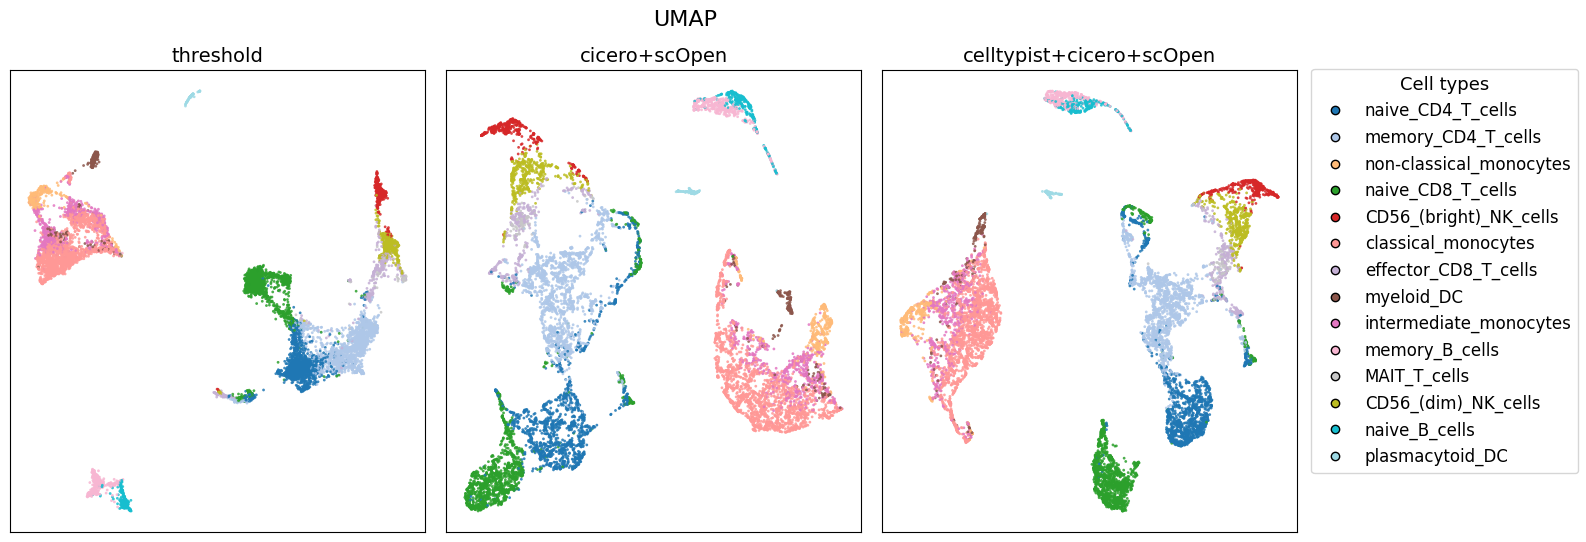

[INFO] Сохранено → canvas_UMAP.png
[INFO] Строим холст: tSNE
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/threshold/metrics_threshold.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/scopen_cicero/matrix_0.4/metrics.pkl
[DEBUG] metrics_path = /home/salimovdr/Datasets/PBMC10k/output/celltypist_cicero_scopen/matrix_0.4/metrics.pkl


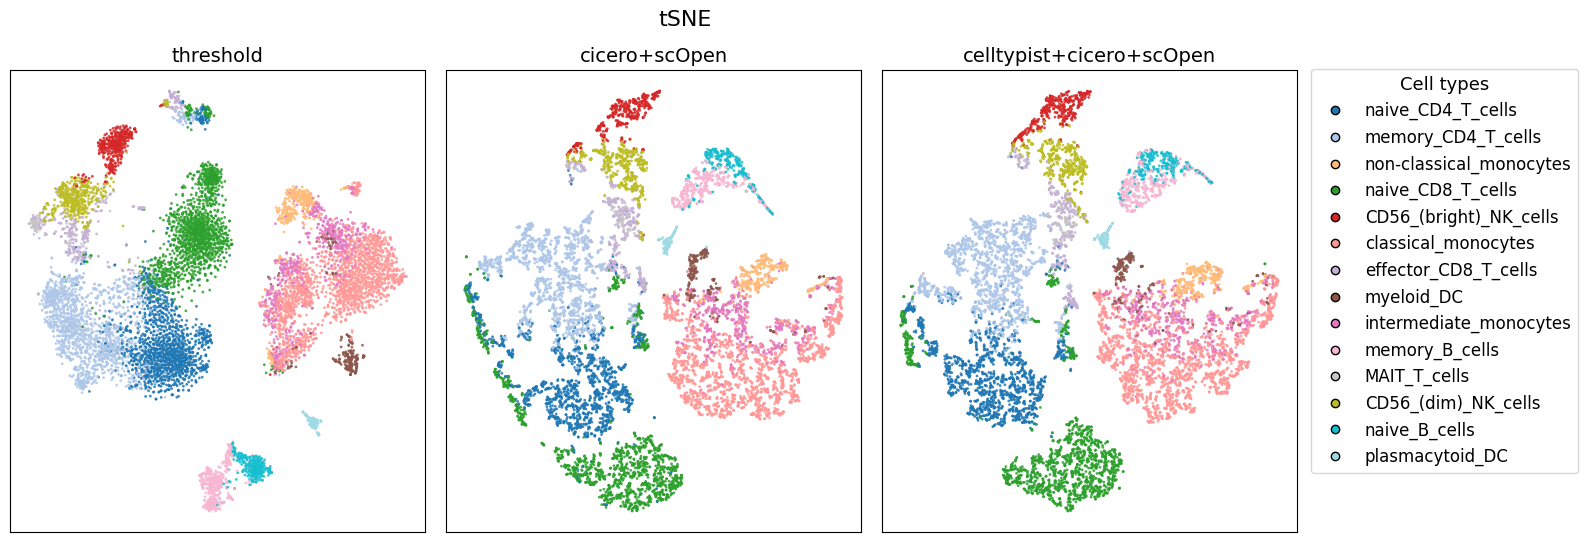

[INFO] Сохранено → canvas_tSNE.png


In [89]:
for emb_key, emb_title in emb_panels:
    print(f"[INFO] Строим холст: {emb_title}")

    # уменьшаем ширину холста (15 вместо 18)
    fig, axes = plt.subplots(
        1, 3,
        figsize=(18, 6)
    )

    # оставляем место справа под легенду
    plt.subplots_adjust(right=0.84, wspace = 0.05)

    for j, (method_name, metrics_path) in enumerate(method_to_metrics.items()):
        ax = axes[j]

        emb_dict = load_embeddings(metrics_path)

        if emb_key not in emb_dict:
            ax.text(0.5, 0.5, f"{emb_title}\nнет в metrics.pkl",
                    fontsize=12, ha="center", va="center")
            ax.axis("off")
            continue

        emb = np.asarray(emb_dict[emb_key])
        emb, labs, cols = align_arrays(emb, labels_all, color_ids_all)

        ax.scatter(
            emb[:, 0],
            emb[:, 1],
            c=cols,
            s=4,
            alpha=0.85,
            linewidths=0
        )

        ax.set_title(method_name, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    # ---- Легенда ----
    legend_elements = [
        plt.Line2D([0], [0],
                   marker='o',
                   color='none',
                   markerfacecolor=base_colors[i],
                   markersize=6,
                   label=str(label_uniques[i]))
        for i in range(n_classes)
    ]

    fig.legend(
        handles=legend_elements,
        title="Cell types",
        fontsize=12,
        title_fontsize=13,
        loc="center right",
       # bbox_to_anchor=(1.18, 0.5),   # ← двигаем дальше вправо
       # borderaxespad=0.
    )

    plt.suptitle(emb_title, fontsize=16)

    out_path = Path(f"./canvas_{emb_title}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print("[INFO] Сохранено →", out_path)
